# Projet numérique : ligne de niveau

Philomène Blot et Elise Costa

## Amorce

Condition raisonnable : comme f est supposée continûment différentiable, alors elle est continue.
Posons g : t -> f(0,t). Par construction, g est aussi continue sur [0,1].

D'après le TVI si f(0,0) = g(0) <= c et si f(0,1) = g(1) >= c ou vice-versa, il existe bien t appartenant à [0,1] tel que g(t) = f(0,t) = c

#### Fonction conforme au squelette

Plusieurs algorithmes existent pour trouver un tel t. Comme l'appel à la fonction qui permettra de l'obtenir est unique, on choisit d'implémenter une dichotomie par soucis de simplicité sur les hypothèses (la complexité de find_seed, ici, partie_entière(log2(eps)), est négligeable devant celle de la fonction contour_simple)

In [15]:
def find_seed(g, c=0, eps=2**(-26)) :
    fa, fb = g(0.0,0.0), g(0.0,1.0)
    
    # on teste si on se trouve dans le cas du TVI
    if (fa > c and fb > c) or (fa < c and fb < c) :
        raise ValueError("Dichotomie impossible")
    
    # on est dans le cas du TVI
    else :
        # on chercher qui de fa ou de fb est plus grand que c
        fpetit = min(fa, fb)
        fgrand = max(fa,fb)
        if fpetit == fa :
            petit, grand = 0, 1
        else :
            petit, grand = 1, 0
            
        m = (petit + grand)/2 
        fm = g(0,m)
        
        while (abs(fm - c) > eps) : 
            if fm >= c :
                grand, fgrand = m, fm
            else :
                petit, fpetit = m, fm
            m = (petit + grand)/2
            fm = g(0,m)
            
        return float(m)

#### test

In [16]:
def g(x,y) :
    return x+y+0.01
find_seed(g,0.5)

0.49000000953674316

La fonction dichotomie fonctionne bien.

## Simple contour

On utilise la méthode de Newton généralisée appliquée à la fonction F :


$\begin{array}{ccccc}
F & : & \mathbb{R}^{2} & \to & \mathbb{R}^{2} \\
 & & \left( \begin{array}{c}
x \\
y \\
\end{array} \right) & \mapsto & \left( \begin{array}{c}
f(x,y)-c \\
(x-x_{n})^2 +(y-y_{n})^2 - \delta^2 \\
\end{array} \right) \\
\end{array}$



On installe autograd :

In [17]:
pip install autograd

Note: you may need to restart the kernel to use updated packages.


On charge les modules dont on aura besoin

In [18]:
from math import sqrt
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

On code les fonctions auxiliaires :

1/ Fonctions pour obtenir le point proche

In [44]:
def norme(X):
    return sqrt(X[0][0]**2 + X[1][0]**2)

def gradient_f(f,a,b) :
    g = autograd.grad
    return np.r_[g(f,0)(float(a),float(b)), g(f,1)(float(a),float(b))]

def pointProche_1(f,x,y, delta) :
    grad = gradient_f(f,float(x),float(y))
    v = np.array([[-grad[1]],[grad[0]]])   
    n = norme(v)
    # on fait attention à ce que le gradient ne soit pas nul
    if n == 0 :
        raise ValueError("Division par 0 interdite")
    else :
        return np.array([[x],[y]]) + (v/n)*delta

# deuxième choix pour le vecteur tangent    
def pointProche_2(f,x,y, delta) :
    grad = gradient_f(f,float(x),float(y))
    v = np.array([[grad[1]],[-grad[0]]])   
    n = norme(v)
    if n == 0 :
        raise ValueError("Division par 0 interdite")
    else :
        return np.array([[x],[y]]) + (v/n)*delta   

2/ Fonctions pour obtenir le nouveau point de la liste

In [45]:
def J_F(F,a,b) :
        j = autograd.jacobian
        return np.c_[j(F,0)(float(a),float(b)), j(F,1)(float(a),float(b))]
    
def Newton(F, v, eps = 2**(-26), maxiter = 100) :
    for _ in range(maxiter) : 
        J_inv = np.linalg.inv(J_F(F, v[0][0],v[1][0]))
        X = v - np.dot(J_inv, F(v[0][0],v[1][0]).T)
        if (norme(X-v) < eps ) : 
            return X
        else :
            v = X
    return(X)

In [40]:
def simple_contour( f, c=0.0, delta= 0.01): 
    x, y = [], []
    try :
        yo = find_seed(f,c)
    except ValueError :
        return x,y
    
    x.append(0)
    y.append(float(yo))
    
    #on a trouvé le premier point    
    bool_continuation = True
    
    def F(a,b) :
             return np.array([f(a,b)-c, (a-x[-1])**2 + (b-y[-1])**2 - delta**5])
    
    # on cherche à partir à droite du côté gauche pour être dans le carré et on suivra toujours ce sens pour la création de la ligne de niveau
    premier_grad = gradient_f(f,x[-1],y[-1])
    if premier_grad[1] >= 0 :
        pointProche = lambda f,x,y,delta : pointProche_2(f,x,y,delta)
    else :
        pointProche = lambda f,x,y,delta : pointProche_1(f,x,y,delta)
    
    
    while bool_continuation : 
        
        # on cherche un premier point proche
        try :
            v = pointProche(f,x[-1],y[-1], delta)
        except ValueError:
            return x,y
        X = Newton(F,v)
        # (a,b) vérifie les conditions voulues pour faire partie de la ligne de niveau i.e. est dans le carré
        a,b = X[0,0],X[1,0]
        if a>=0 and a<=1 and b>=0 and b<=1 :
            x.append(a)
            y.append(b)
        else :
            bool_continuation = False
    
    return x,y

Test

In [41]:
def f(x,y) : 
    return(x**2+y**2 - 0.5)

In [42]:
x,y = simple_contour(f, c=0.3)

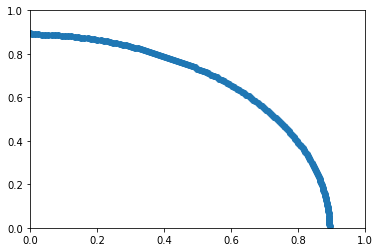

In [35]:
plt.scatter(x,y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()